Epoch[1/25], G Loss: -0.1082, D Loss: -0.6292, IPM ratio: 0.4334, Lambda: -0.0003


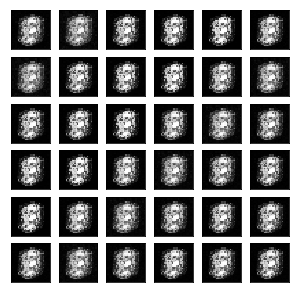

Epoch[2/25], G Loss: -0.1018, D Loss: -0.6664, IPM ratio: 0.7267, Lambda: -0.0007


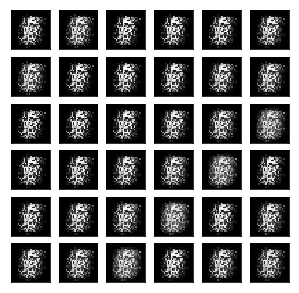

Epoch[3/25], G Loss: -0.0911, D Loss: -0.7752, IPM ratio: 0.6942, Lambda: -0.0010


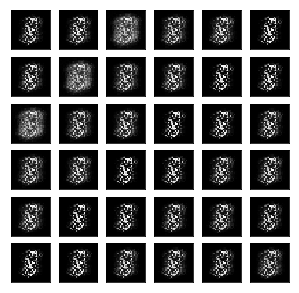

Epoch[4/25], G Loss: -0.1756, D Loss: -0.6793, IPM ratio: 0.2575, Lambda: -0.0013


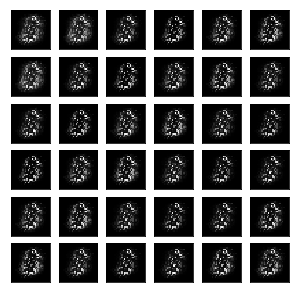

Epoch[5/25], G Loss: -0.1983, D Loss: -0.6294, IPM ratio: 0.2602, Lambda: -0.0015


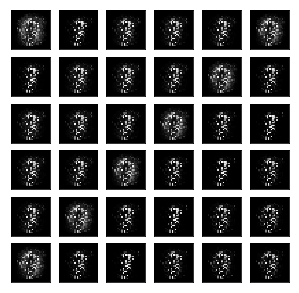

Epoch[6/25], G Loss: -0.0875, D Loss: -0.7318, IPM ratio: 0.7843, Lambda: -0.0018


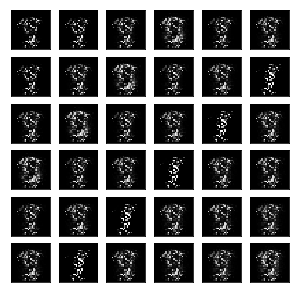

Epoch[7/25], G Loss: -0.0320, D Loss: -0.9365, IPM ratio: 0.7849, Lambda: -0.0021


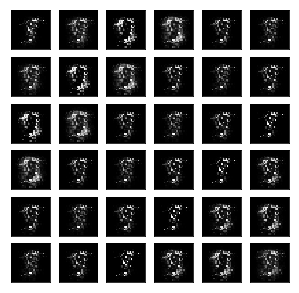

Epoch[8/25], G Loss: -0.0935, D Loss: -0.7818, IPM ratio: 0.9017, Lambda: -0.0024


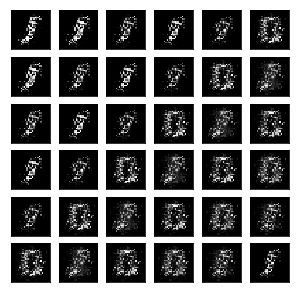

Epoch[9/25], G Loss: -0.0833, D Loss: -0.7732, IPM ratio: 0.5941, Lambda: -0.0027


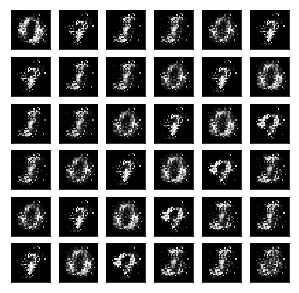

Epoch[10/25], G Loss: -0.1294, D Loss: -0.5964, IPM ratio: 0.3926, Lambda: -0.0030


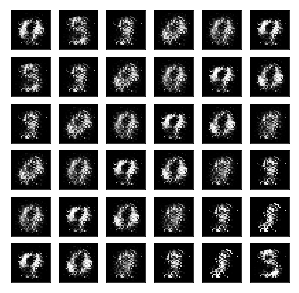

Epoch[11/25], G Loss: -0.1071, D Loss: -0.5375, IPM ratio: 0.4992, Lambda: -0.0033


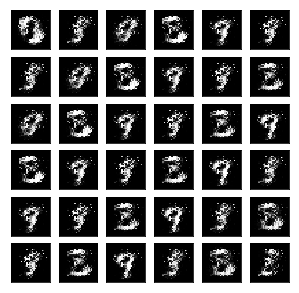

Epoch[12/25], G Loss: -0.0685, D Loss: -0.6886, IPM ratio: 0.4727, Lambda: -0.0036


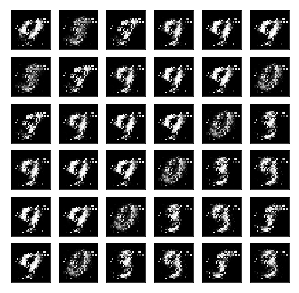

Epoch[13/25], G Loss: -0.0578, D Loss: -0.6340, IPM ratio: 0.5788, Lambda: -0.0040


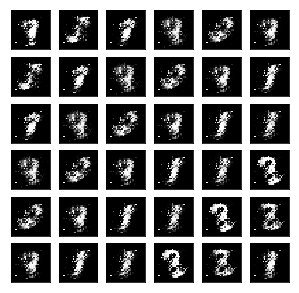

Epoch[14/25], G Loss: -0.0649, D Loss: -0.6696, IPM ratio: 0.6782, Lambda: -0.0043


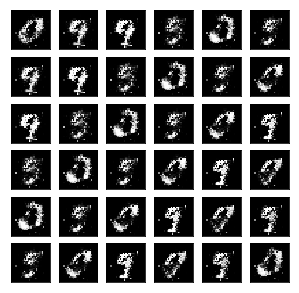

Epoch[15/25], G Loss: -0.0557, D Loss: -0.7011, IPM ratio: 0.8208, Lambda: -0.0046


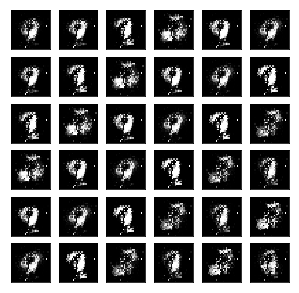

Epoch[16/25], G Loss: -0.0726, D Loss: -0.6985, IPM ratio: 0.8319, Lambda: -0.0049


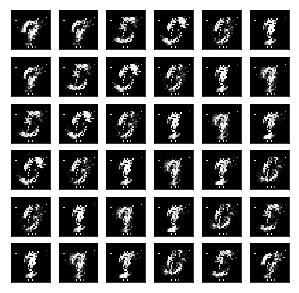

Epoch[17/25], G Loss: -0.0736, D Loss: -0.7841, IPM ratio: 0.5538, Lambda: -0.0052


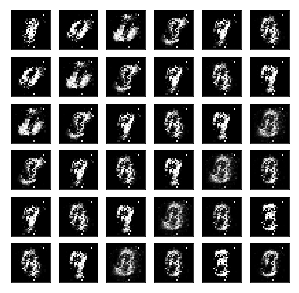

Epoch[18/25], G Loss: -0.1435, D Loss: -0.5847, IPM ratio: 0.8089, Lambda: -0.0055


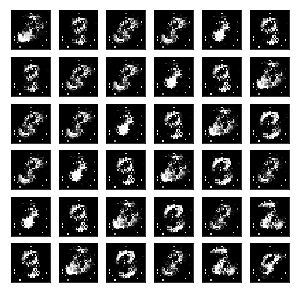

Epoch[19/25], G Loss: -0.0707, D Loss: -0.7949, IPM ratio: 0.4598, Lambda: -0.0058


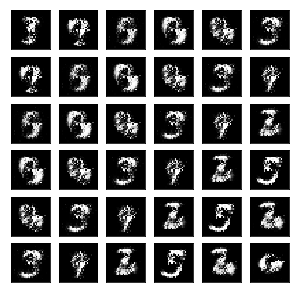

Epoch[20/25], G Loss: -0.1050, D Loss: -0.6309, IPM ratio: 0.7939, Lambda: -0.0061


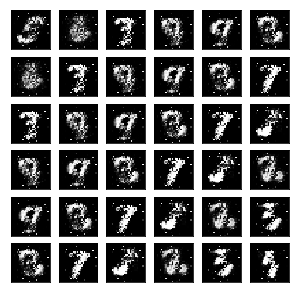

Epoch[21/25], G Loss: -0.0695, D Loss: -0.7809, IPM ratio: 0.7090, Lambda: -0.0064


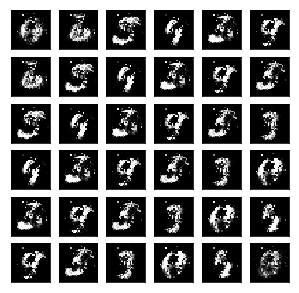

Epoch[22/25], G Loss: -0.0803, D Loss: -0.7491, IPM ratio: 0.7063, Lambda: -0.0067


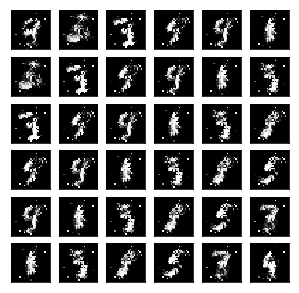

Epoch[23/25], G Loss: -0.0551, D Loss: -0.8411, IPM ratio: 0.7596, Lambda: -0.0070


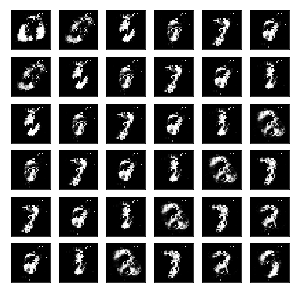

Epoch[24/25], G Loss: -0.0660, D Loss: -0.7987, IPM ratio: 0.8147, Lambda: -0.0073


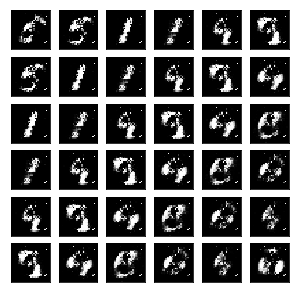

Epoch[25/25], G Loss: -0.0595, D Loss: -0.8209, IPM ratio: 0.8432, Lambda: -0.0076


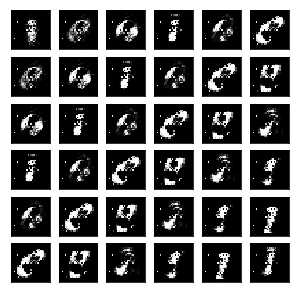

In [5]:
""" (FisherGAN)

From the abstract:
"In this paper we introduce Fisher GAN which fits within the 
Integral Probability Metrics (IPM) framework for training GANs. 
Fisher GAN defines a critic with a data dependent constraint on 
its second order moments. We show in this paper that Fisher GAN 
allows for stable and time efficient training that does not 
compromise the capacity of the critic, and does not need data 
independent constraints such as weight clipping."

Integral Probability Metrics (IPM) framework simply means that
the outputs of the discriminator can be interpretted 
probabilistically. This is similar to WGAN/WGAN-GP. Whereas
WGAN-GP uses a penalty on the gradients of the critic, FisherGAN
imposes a constraint on the second order moments of the critic.
Also, the Fisher IPM corresponds to the Chi-squared distance
between distributions.

The main empirical claims are that FisherGAN yields better
inception scores and has less computational overhead than WGAN.

https://arxiv.org/pdf/1606.07536.pdf
"""

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from tqdm import tqdm_notebook
from load_data import get_data

def to_var(x):
    """ Make a tensor cuda-erized and requires gradient """
    return to_cuda(x).requires_grad_()

def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x


# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
# train_iter, val_iter, test_iter = get_data()


class Generator(nn.Module):
    """ Generator. Input is noise, output is a generated image. 
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = torch.sigmoid(self.generate(activated))
        return generation


class Discriminator(nn.Module):
    """ Discriminator. Input is an image (real or generated), output is P(generated).
    """
    def __init__(self, image_size, hidden_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = torch.sigmoid(self.discriminate(activated))
        return discrimination


class FisherGAN(nn.Module):
    """ Super class to contain both Discriminator (D) and Generator (G) 
    """
    def __init__(self, image_size, hidden_dim, z_dim, output_dim=1):
        super().__init__()
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        
        self.z_dim = z_dim

    
class FisherGANTrainer:
    """ Object to hold data iterators, train a GAN variant 
    """
    def __init__(self, model, train_iter, val_iter, test_iter, viz=False):
        self.model = to_cuda(model)
        self.name = model.__class__.__name__
        
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
        
        self.Glosses = []
        self.Dlosses = []
        
        self.viz = viz
            
    def train(self, num_epochs, G_lr=1e-4, D_lr=1e-4, D_steps=1, LAMBDA=0., RHO=1e-6):
        """ Train FisherGAN using IPM framework
            Logs progress using G loss, D loss, G(x), D(G(x)), IPM ratio (want close to 0.50),
            Lambda (want close to 0), and visualizations of Generator output.

        Inputs:
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 1e-4)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 1e-4)
            D_steps: int, training step ratio for how often to train D compared to G (default 1)
            LAMBDA: float, initial weight on constraint term (default 0.)
            RHO: float, quadratic penalty weight (default 1e-6)
        """
        # Initialize alpha
        self.LAMBDA = to_var(torch.zeros(1))
        self.RHO = to_var(torch.tensor(RHO))
        
        # Initialize optimizers
        G_optimizer = torch.optim.Adam(params=[p for p in self.model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.Adam(params=[p for p in self.model.D.parameters() if p.requires_grad], lr=D_lr)
    
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs+1)):
            self.model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                for _ in range(D_steps): 

                    # Reshape images
                    images = self.process_batch(self.train_iter)

                    # TRAINING D: Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator to learn to discriminate between real and generated images
                    D_loss, IPM_ratio = self.train_D(images)
                    
                    # Update parameters
                    D_loss.backward()
                    
                    # Minimize lambda for 'artisinal SGD'
                    self.LAMBDA = self.LAMBDA + self.RHO*self.LAMBDA.grad
                    self.LAMBDA = to_cuda(self.LAMBDA.detach().requires_grad_(True))
                    
                    # Now step optimizer
                    D_optimizer.step()
                    
                    # Log results, backpropagate the discriminator network
                    D_step_loss.append(D_loss.item())
                                                        
                # So that G_loss and D_loss have the same number of entries.
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G
                G_optimizer.zero_grad()

                # Train the generator to generate images that fool the discriminator
                G_loss = self.train_G(images)
                
                # Log results, update parameters
                G_losses.append(G_loss.item())
                G_loss.backward()
                G_optimizer.step()
            
            # Save progress
            self.Glosses.extend(G_losses)
            self.Dlosses.extend(D_losses)
                            
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f, IPM ratio: %.4f, Lambda: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses),
                     IPM_ratio, self.LAMBDA)) 
            self.num_epochs = epoch
            
            # Visualize generator progress
            self.generate_images(epoch)
            
            if self.viz:
                plt.show()
                
    def train_D(self, images):
        """ Run 1 step of training for discriminator

        Input:
            images: batch of images (reshaped to [batch_size, 784])
        Output:
            D_loss: FisherGAN IPM loss
        """    
        # Generate labels (ones indicate real images, zeros indicate generated)
        X_labels = to_cuda(torch.ones(images.shape[0], 1)) 
        G_labels = to_cuda(torch.zeros(images.shape[0], 1)) 
        
        # Classify the real batch images, get the loss for these 
        DX_score = self.model.D(images)
        
        # Sample noise z, generate output G(z), discriminate D(G(z))
        noise = self.compute_noise(images.shape[0], model.z_dim)
        G_output = self.model.G(noise)
        DG_score = self.model.D(G_output)
        
        # First and second order central moments (Gaussian assumed)
        DX_moment_1, DG_moment_1  = DX_score.mean(), DG_score.mean()
        DX_moment_2, DG_moment_2 = (DX_score**2).mean(), (DG_score**2).mean()
        
        # Compute constraint on second order moments
        OMEGA = 1 - (0.5*DX_moment_2 + 0.5*DG_moment_2)

        # Compute loss (Eqn. 9, but differs slightly since we optimize negative gradients)
        D_loss = -((DX_moment_1-DG_moment_1) + self.LAMBDA*OMEGA - (self.RHO/2)*(OMEGA**2))
        
        # For progress logging
        IPM_ratio = DX_moment_1.item() - DG_moment_1.item() \
                    / 0.5*(DX_moment_2.item() - DG_moment_2.item())**0.5

        return D_loss, IPM_ratio
    
    def train_G(self, images):
        """ Run 1 step of training for generator
        
        Input:
            images: batch of images reshaped to [batch_size, -1]    
        Output:
            G_loss: FisherGAN IPM loss
        """ 
        
        # Get noise (denoted z), classify it using G, then classify the output of G using D.
        noise = self.compute_noise(images.shape[0], self.model.z_dim) # z
        G_output = self.model.G(noise) # G(z)
        DG_score = self.model.D(G_output) # D(G(z))
        
        # Compute loss by minimizing mean difference
        G_loss = -DG_score.mean()
        
        return G_loss
    
    def compute_noise(self, batch_size, z_dim):
        """ Compute random noise for the generator to learn to make images from """
        return to_cuda(torch.randn(batch_size, z_dim))
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_cuda(images.view(images.shape[0], -1))
        return images
    
    def generate_images(self, epoch, num_outputs=36, save=True):
        """ Visualize progress of generator learning """
        # Turn off any regularization
        self.model.eval()
        
        # Sample noise vector
        noise = self.compute_noise(num_outputs, self.model.z_dim)
        
        # Transform noise to image
        images = self.model.G(noise)
        
        # Reshape to proper image size
        images = images.view(images.shape[0], 28, 28)
        
        # Plot
        plt.close()
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        # Save images if desired
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(images.unsqueeze(1).data, 
                                         outname + 'reconst_%d.png'
                                         %(epoch), nrow = 5)
    
    def viz_loss(self):
        """ Visualize loss for the generator, discriminator """
        # Set style, figure size
        plt.style.use('ggplot')
        plt.rcParams["figure.figsize"] = (8,6)

        # Plot Discriminator loss in red, Generator loss in green
        plt.plot(np.linspace(1, self.num_epochs, len(self.Dlosses)), self.Dlosses, 'r')
        plt.plot(np.linspace(1, self.num_epochs, len(self.Dlosses)), self.Glosses, 'g')
        
        # Add legend, title
        plt.legend(['Discriminator', 'Generator'])
        plt.title(self.name)
        plt.show()

    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)
    
    def load_model(self, loadpath):
        """ Load state dictionary into model """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)


model = FisherGAN(image_size=784, 
                  hidden_dim=256, 
                  z_dim=128)

trainer = FisherGANTrainer(model=model, 
                           train_iter=train_iter, 
                           val_iter=val_iter, 
                           test_iter=test_iter,
                           viz=True)

trainer.train(num_epochs=25, 
              G_lr=1e-4, 
              D_lr=1e-4, 
              D_steps=1)